In [1]:
import warnings
from typing import Dict, Any, Tuple

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.data import DataLoader, PersistentDataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss
from monai.metrics import DiceHelper
from monai.networks.nets import UNet
import monai.transforms as T
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelRecall, MultilabelAUROC, MultilabelPrecision
from transformers import get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
from pathlib import Path

/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os

SEG_DIR = '/home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI'
CLASSIFICATION_DATA_DIR = '/home/tibia/Projet_Hemorragie/MBH_label_case'
SAVE_DIR = "/home/tibia/Projet_Hemorragie/MBH_multitask_log"
os.makedirs(SAVE_DIR, exist_ok=True)

NUM_CLASSES = 6
CLASS_NAMES = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

In [3]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cuda', index=1)

# Vérfier que les CT Scans sont différents

In [ ]:
import os

SEG_DIR = '/home/tibia/Projet_Hemorragie/MBH_SEG_2025_LLG_2025_06_12/imagesTr'
CLASSIFICATION_DATA_DIR = '/home/tibia/Projet_Hemorragie/MBH_label_case'


seg_files = set(os.listdir(SEG_DIR))
classif_files = set(os.listdir(CLASSIFICATION_DATA_DIR))

# Fichiers communs
common_files = seg_files & classif_files

# Fichiers spécifiques à chaque dossier
only_in_seg = seg_files - classif_files
only_in_classif = classif_files - seg_files

print(f"Nombre de fichiers dans SEG_DIR : {len(seg_files)}")
print(f"Nombre de fichiers dans CLASSIFICATION_DATA_DIR : {len(classif_files)}")
print(f"Nombre de fichiers communs : {len(common_files)}")
print(f"\nExemples communs : {list(common_files)[:5]}")

print(f"\nFichiers uniquement dans SEG_DIR : {len(only_in_seg)}")
print(f"Exemples : {list(only_in_seg)[:5]}")

print(f"\nFichiers uniquement dans CLASSIFICATION_DATA_DIR : {len(only_in_classif)}")
print(f"Exemples : {list(only_in_classif)[:5]}")

Nombre de fichiers dans SEG_DIR : 192
Nombre de fichiers dans CLASSIFICATION_DATA_DIR : 1982
Nombre de fichiers communs : 1

Exemples communs : ['ID_3be7cc35_ID_cf2643c5a8.nii.gz']

Fichiers uniquement dans SEG_DIR : 191
Exemples : ['ID_3e481fc5_ID_750530c215.nii.gz', 'ID_cb4c887c_ID_ec2a4643f3.nii.gz', 'ID_a429fd9a_ID_2eabc43f3d.nii.gz', 'ID_a1703be5_ID_d0e02f0443.nii.gz', 'ID_5f53ab26_ID_f1c7d54a53.nii.gz']

Fichiers uniquement dans CLASSIFICATION_DATA_DIR : 1981
Exemples : ['ID_b5a546db_ID_a008d70806.nii.gz', 'ID_0685c3cb_ID_a44a99c41b.nii.gz', 'ID_abdba136_ID_05f1970bac.nii.gz', 'ID_9c138c03_ID_d640907eaa.nii.gz', 'ID_1a7ca051_ID_6cc5549a4b.nii.gz']


In [ ]:
try : 
    ! pip install torchinfo

except:
    print("torchinfo is already installed or installation failed.")
    
import torchinfo
from torchinfo import summary
# Display model summary
model = model.to(DEVICE)
summary(model, input_size=(BATCH_SIZE, 1, 224, 224,144))


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 6]                   --
├─Conv3d: 1-1                            [32, 32, 112, 112, 72]    10,976
├─BatchNorm3d: 1-2                       [32, 32, 112, 112, 72]    64
├─ReLU: 1-3                              [32, 32, 112, 112, 72]    --
├─MaxPool3d: 1-4                         [32, 32, 56, 56, 36]      --
├─Sequential: 1-5                        [32, 32, 56, 56, 36]      --
│    └─ResNetBlock: 2-1                  [32, 32, 56, 56, 36]      --
│    │    └─Conv3d: 3-1                  [32, 32, 56, 56, 36]      27,648
│    │    └─BatchNorm3d: 3-2             [32, 32, 56, 56, 36]      64
│    │    └─ReLU: 3-3                    [32, 32, 56, 56, 36]      --
│    │    └─Conv3d: 3-4                  [32, 32, 56, 56, 36]      27,648
│    │    └─BatchNorm3d: 3-5             [32, 32, 56, 56, 36]      64
│    │    └─ReLU: 3-6                    [32, 32, 56, 56, 36]      --
├─S

: 

In [13]:
from timeit import default_timer as timer
def print_train_time(start:float,end:float,device:torch.device=None):
    total_time=end-start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def compute_accuracy(y_pred, y_true, threshold=0.5):
    """
    Renvoie l'accuracy multilabel (exact match pour chaque label indépendamment).
    """
    preds = torch.sigmoid(y_pred) > threshold
    #print(f"preds: {preds}")
    correct = (preds == y_true.bool()).float()
    #print(f"correct: {correct}")
    return correct.mean().item()



In [14]:
def train_step(model:torch.nn.Module,
                dataloader:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                optimizer:torch.optim,
                device:torch.device=DEVICE):
   
    train_loss=0


    model.train()

    for i, batch in enumerate(dataloader):
      X = batch["image"].to(device)
      y = batch["label"].to(device)
    
      #1. forward pass (output the raw logits from the model )
      y_pred=model(X)

      #2. Calculate loss and accuracy (per batch)
      loss=loss_fn(y_pred,y)
      train_loss += loss


      #3. Optimizer zero grad 
      optimizer.zero_grad()

      #4. Loss backward
      loss.backward()

      #5. Optimizer step
      
      optimizer.step()
      #Divide total train loss and acc by lenght of train dataloader
    
      if (i% 400 == 0):
        print(f"Looked at {i * len(X)}/{len(dataloader.dataset)} samples")
      
    train_loss /= len(dataloader)
   

    print(f"Train loss: {train_loss:.5f} ")


def val_step(model:torch.nn.Module,
                dataloader:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                device:torch.device=DEVICE):
    """Performs a testing loop step on model going over data_loader"""
   
    test_loss=0


    model.eval()

    with torch.inference_mode():
      for batch,(X_test,y_test) in enumerate(dataloader):
     
        X_test,y_test=X_test.to(device),y_test.to(device)

      #1. forward pass (output the raw logits from the model )
        test_pred=model(X_test)

      #2. Calculate loss and accuracy (per batch)
        loss=loss_fn(test_pred,y_test)
        test_loss += loss
        test_acc += compute_accuracy(y_true=y_test,y_pred=test_pred) # go from logits -> prediction labels
     
        if (batch % 400 == 0):
          print(f"Looked at {batch * len(X_test)}/{len(dataloader.dataset)} samples")
    #Divide total test loss and acc by lenght of test dataloader
      test_loss /= len(dataloader)
   

      print(f"Test loss: {test_loss:.5f} ")

In [ ]:
# # === Training Loop ===
# from tqdm import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n-------")
    train_step(model=model,
               dataloader=train_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
     
               device=DEVICE)
    

end_time = timer()
total_train_time = print_train_time(start_time, end_time, DEVICE)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------


/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/monai/data/utils.py", line 517, in list_data_collate
    ret[key] = collate_fn(data_for_batch)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/monai/data/utils.py", line 456, in collate_meta_tensor_fn
    collated = collate_tensor_fn(batch)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/monai/data/meta_tensor.py", line 282, in __torch_function__
    ret = super().__torch_function__(func, types, args, kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/torch/_tensor.py", line 1512, in __torch_function__
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
RuntimeError: stack expects each tensor to be equal size, but got [1, 224, 224, 136] at entry 0 and [1, 224, 224, 137] at entry 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/monai/data/utils.py", line 532, in list_data_collate
    raise RuntimeError(re_str) from re
RuntimeError: stack expects each tensor to be equal size, but got [1, 224, 224, 136] at entry 0 and [1, 224, 224, 137] at entry 1
Collate error on the key 'image' of dictionary data.

MONAI hint: if your transforms intentionally create images of different shapes, creating your `DataLoader` with `collate_fn=pad_list_data_collate` might solve this problem (check its documentation).


> collate dict key "image" out of 2 keys
>> collate/stack a list of tensors
>> E: stack expects each tensor to be equal size, but got [1, 224, 224, 157] at entry 0 and [1, 224, 224, 181] at entry 1, shape [torch.Size([1, 224, 224, 157]), torch.Size([1, 224, 224, 181]), torch.Size([1, 224, 224, 176]), torch.Size([1, 224, 224, 156]), torch.Size([1, 224, 224, 156]), torch.Size([1, 224, 224, 156]), torch.Size([1, 224, 224, 176]), torch.Size([1, 224, 224, 166]), torch.Size([1, 224, 224, 176]), torch.Size([1, 224, 224, 134]), torch.Size([1, 224, 224, 157]), torch.Size([1, 224, 224, 154]), torch.Size([1, 224, 224, 157]), torch.Size([1, 224, 224, 191]), torch.Size([1, 224, 224, 181]), torch.Size([1, 224, 224, 166]), torch.Size([1, 224, 224, 155]), torch.Size([1, 224, 224, 166]), torch.Size([1, 224, 224, 196]), torch.Size([1, 224, 224, 155]), torch.Size([1, 224, 224, 157]), torch.Size([1, 224, 224, 136]), torch.Size([1, 224, 224, 158]), torch.Size([1, 224, 224, 156]), torch.Size([1, 224, 224, 1

: 


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


/tmp/ipykernel_715640/3311561745.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Hemorrhage Type', y='AUC', data=df, palette='viridis')


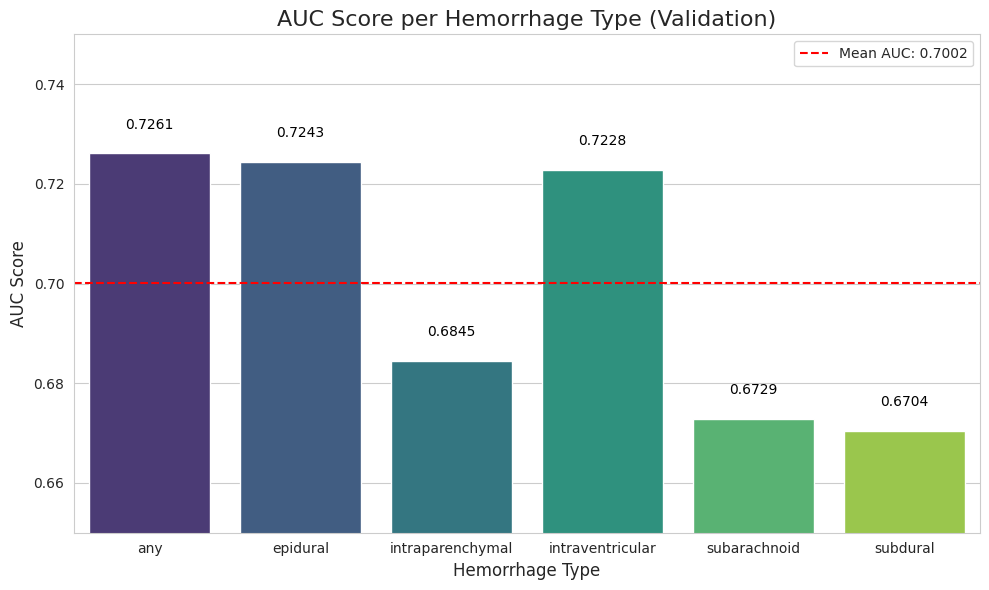


--- Interpretation ---
While the AUC scores vary somewhat, they generally fall within a similar range.
The primary concern remains the 0.0000 recall and precision, which suggests the model is not making positive predictions or is doing so with very low confidence.
This plot helps visualize the individual category performances, but the root cause of the zero recall/precision needs further investigation.


In [14]:
! pip install seaborn 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data provided
data = {
    'Hemorrhage Type': ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural'],
    'AUC': [0.7261, 0.7243, 0.6845, 0.7228, 0.6729, 0.6704]
}

df = pd.DataFrame(data)

# Set a nice style for the plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create the bar plot
barplot = sns.barplot(x='Hemorrhage Type', y='AUC', data=df, palette='viridis')

# Add titles and labels
plt.title('AUC Score per Hemorrhage Type (Validation)', fontsize=16)
plt.xlabel('Hemorrhage Type', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)
plt.ylim(0.65, 0.75) # Set y-axis limits to focus on the range of AUC values

# Add the exact AUC values on top of the bars
for index, row in df.iterrows():
    barplot.text(row.name, row.AUC + 0.005, round(row.AUC, 4), color='black', ha="center")

# Add a horizontal line for the mean AUC for reference
plt.axhline(y=0.7002, color='r', linestyle='--', label=f'Mean AUC: 0.7002')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

print("\n--- Interpretation ---")
print("While the AUC scores vary somewhat, they generally fall within a similar range.")
print("The primary concern remains the 0.0000 recall and precision, which suggests the model is not making positive predictions or is doing so with very low confidence.")
print("This plot helps visualize the individual category performances, but the root cause of the zero recall/precision needs further investigation.")

In [16]:
import pathlib
# It's common practice to import pathlib.Path directly as Path for convenience
from pathlib import Path

file_path = Path("/home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/split_info/train_files.txt")

print(f"File path: {file_path}")

# To check if the file exists:
if file_path.exists():
    print(f"File exists: {file_path.exists()}")
    # If you want to get the number of characters in the file (its content length)
    # you would need to open and read it.
    try:
        with open(file_path, 'r') as f:
            content = f.read()
            print(f"Length of file content (characters): {len(content)}")
            # If it's a file with one file path per line and you want to count lines:
            f.seek(0) # Reset file pointer to the beginning
            lines = f.readlines()
            print(f"Number of lines in file: {len(lines)}")

    except Exception as e:
        print(f"Error reading file: {e}")
else:
    print(f"File does not exist at: {file_path}")

File path: /home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/split_info/train_files.txt
File exists: True
Length of file content (characters): 5082
Number of lines in file: 154
